In [2]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')

In [3]:
cornel_box = mi.load_file("./scenes/cbox_one_ball.xml")
img = mi.render(cornel_box, spp=128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


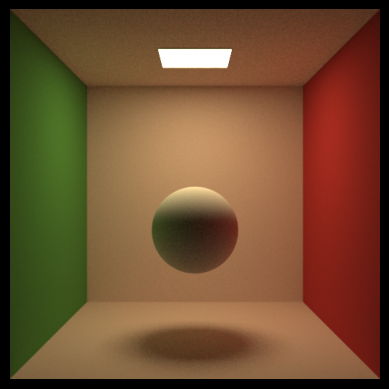

In [4]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(img ** (1/2.2))
mi.util.write_bitmap('trans_sensor.exr', img)

In [5]:
params = mi.traverse(cornel_box)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type  Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float PerspectiveCamera
  sensor.far_clip                               float PerspectiveCamera
  sensor.shutter_open                           float PerspectiveCamera
  sensor.shutter_open_time                      float PerspectiveCamera
  sensor.film.size                              ScalarVector2u HDRFilm
  sensor.film.crop_size                         ScalarVector2u HDRFilm
  sensor.film.crop_offset                       ScalarPoint2u HDRFilm
  sensor.x_fov                         ∂, D     Float PerspectiveCamera
  sensor.to_world                      ∂, D     Transform4f PerspectiveCamera
  gray.reflectance.value               ∂        Color3f SRGBReflectanceSpectrum
  white.re

In [6]:
print(params['graysphere.to_world'], params['sensor.film.size'])

[[[0.3, 0, 0, 0],
  [0, 0.3, 0, -0.25],
  [0, 0, 0.3, 0.2],
  [0, 0, 0, 1]]] [512, 512]


In [7]:
params['sensor.film.size'] = [2048, 2048]
params.update()

[(HDRFilm[
    size = [2048, 2048],
    crop_size = [2048, 2048],
    crop_offset = [0, 0],
    sample_border = 0,
    compensate = 0,
    filter = TentFilter[radius=1.000000],
    file_format = OpenEXR,
    pixel_format = rgb,
    component_format = float32,
  ],
  {'size'}),
 (PerspectiveCamera[
    x_fov = [39.3077],
    near_clip = 0.001,
    far_clip = 100,
    film = HDRFilm[
      size = [2048, 2048],
      crop_size = [2048, 2048],
      crop_offset = [0, 0],
      sample_border = 0,
      compensate = 0,
      filter = TentFilter[radius=1.000000],
      file_format = OpenEXR,
      pixel_format = rgb,
      component_format = float32,
    ],
    sampler = IndependentSampler[
      base_seed = 0
      sample_count = 128
      samples_per_wavefront = 128
      wavefront_size = 33554432
    ],
    resolution = [2048, 2048],
    shutter_open = 0,
    shutter_open_time = 0,
    to_world = [[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, -1, 3.8],
               

In [8]:
import numpy as np
ROT_CENT = np.array([0, -.25, .2])
ROT_AX = np.array([0, 0, 1])
ROT_RAD = .5
SPHERE_RAD = .3
def get_to_world_mat(t : float):
    tmp_mat = np.array(
       [[SPHERE_RAD, .0, ROT_CENT[0], ROT_CENT[0] + np.sin(np.pi * 2 * t) * ROT_RAD], 
         [.0, SPHERE_RAD, 0, ROT_CENT[1] + np.cos(np.pi * 2 * t) * ROT_RAD],
         [.0, .0, SPHERE_RAD, ROT_CENT[2]],
         [.0, .0, .0, .1]
       ]
    )
    return mi.Transform4f(tmp_mat)

# def get_to_world_mat(t : float):
#     return mi.Transform4f().rotate(axis=ROT_AX, angle=t*360).translate(ROT_CENT + np.array([0, 0, ROT_RAD]))



In [9]:
print(get_to_world_mat(.4))

[[[0.3, 0, 0, 0.293893],
  [0, 0.3, 0, -0.654508],
  [0, 0, 0.3, 0.2],
  [0, 0, 0, 0.1]]]


In [10]:
FRAME_CNT=20

aov_int = mi.load_dict({
    'type': 'aov',
    'aovs': 'albedo:albedo,normals:sh_normal,depth:depth,position:position',
    'integrator': {
        'type': 'path',
    }
})

cur_frame = 0
for t in np.linspace(0, 1, FRAME_CNT):
    mat = get_to_world_mat(t)
    params['graysphere.to_world'] = mat
    params.update()
    frame = mi.render(cornel_box, integrator=aov_int, spp=512)
    alb_img = frame[:,:,3:6]
    mi.util.write_bitmap('./in/albedo_{}.exr'.format(cur_frame), alb_img)
    norm_img = frame[:,:,6:9]
    mi.util.write_bitmap('./in/normal_{}.exr'.format(cur_frame), norm_img)
    dep_img = frame[:,:,9:10]
    mi.util.write_bitmap('./in/depth_{}.exr'.format(cur_frame), dep_img)
    pos_img = frame[:,:,10:13]
    mi.util.write_bitmap('./in/position_{}.exr'.format(cur_frame), pos_img)
    sensor = cornel_box.sensors()[0]
    noisy_multichannel = sensor.film().bitmap()
    denoiser = mi.OptixDenoiser(input_size=noisy_multichannel.size(), albedo=True, normals=True, temporal=False)
    col_img = frame[:,:,0:3]
    to_sensor = sensor.world_transform().inverse()
    de_col_img = denoiser(noisy_multichannel, albedo_ch="albedo", normals_ch="normals", to_sensor=to_sensor)
    mi.util.write_bitmap('./in/beauty_{}.exr'.format(cur_frame), de_col_img)
    cur_frame+=1